## Toxic comment classifier

In [1]:
# importing dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import nltk
import string
import nlp_utils
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

### Importing a dataset and understanding it

In [3]:
# import dataset
df = pd.read_csv('data/train.csv')

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
# checking for number of null values
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
# counts of toxic and non toxic comments
df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [8]:
# counts of sever toxic and non sever toxic comments
df['severe_toxic'].value_counts()

0    157976
1      1595
Name: severe_toxic, dtype: int64

In [9]:
# counts of obscene and non obscene comments
df['obscene'].value_counts()

0    151122
1      8449
Name: obscene, dtype: int64

In [10]:
# counts of threat and non threatning comments
df['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [11]:
# counts of insult and non insulting comments
df['insult'].value_counts()

0    151694
1      7877
Name: insult, dtype: int64

In [12]:
# counts of identity hate sentences
df['identity_hate'].value_counts()

0    158166
1      1405
Name: identity_hate, dtype: int64

**0 --> non instult**

**1 --> insult**

### Data visualization

In [13]:
# using only numeric columns
sentencetype_graph = df.iloc[:, 2:].sum()

In [14]:
sentencetype_graph

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

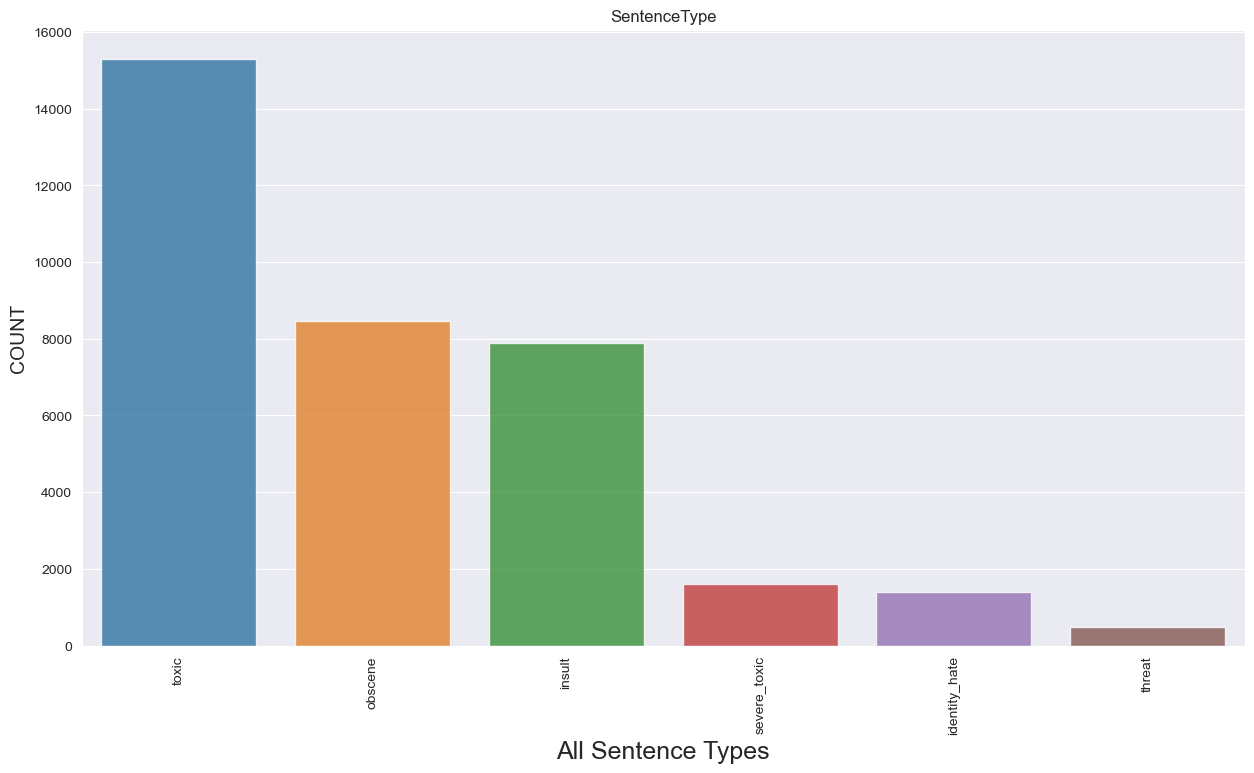

In [15]:
sns.set_style("darkgrid")
ls=sentencetype_graph.sort_values(ascending=False)
plt.figure(figsize=(15,8))
temp =sns.barplot(x=ls.index, y=ls.values, alpha=0.8) 
plt.title('SentenceType')
plt.ylabel('COUNT', fontsize=14)
plt.xlabel('All Sentence Types', fontsize=18)
temp.set_xticklabels(rotation=90,labels=ls.index,fontsize=10)
plt.show()

### Text preprocessing

In [16]:
df['comment_text'][10]

'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

In [17]:
# removing special characters
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub('\n', ' ', x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]', r' ', x)
df['comment_text'] = df['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [18]:
# creating insult dataframe
insulting_comment_df = df.loc[:, ['id', 'comment_text', 'insult']]

In [19]:
# creating identity hate dataframe
identityhate_comment_df = df.loc[:, ['id', 'comment_text', 'identity_hate']]

In [20]:
# creating obscene comment dataframe
obscene_comment_df = df.loc[:, ['id', 'comment_text', 'obscene']]

In [21]:
# creating threatening dataframe
threatening_comment_df = df.loc[:, ['id', 'comment_text', 'threat']]

In [22]:
# creating severe toxic dataframe
severetoxic_comment_df = df.loc[:, ['id', 'comment_text', 'severe_toxic']]

In [23]:
# creating toxic comment dataframe
toxic_comment_df = df.loc[:, ['id', 'comment_text', 'toxic']]

In [24]:
# subset datasets

In [25]:
severetoxic_comment_df

,id,comment_text,severe_toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0
...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when ...,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ...,0
159568,ffee36eab5c267c9,spitzer umm theres no actual article for pr...,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0


In [26]:
threatening_comment_df

,id,comment_text,threat
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0
...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when ...,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ...,0
159568,ffee36eab5c267c9,spitzer umm theres no actual article for pr...,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0


In [27]:
obscene_comment_df

,id,comment_text,obscene
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0
...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when ...,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ...,0
159568,ffee36eab5c267c9,spitzer umm theres no actual article for pr...,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0


In [28]:
toxic_comment_df

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0
...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when ...,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ...,0
159568,ffee36eab5c267c9,spitzer umm theres no actual article for pr...,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0


In [29]:
identityhate_comment_df

,id,comment_text,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0
...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when ...,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ...,0
159568,ffee36eab5c267c9,spitzer umm theres no actual article for pr...,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0


### Balancing the target column in the dataset

In [30]:
# selecting only 5000 toxic comments
toxic_comment_balanced_1 = toxic_comment_df[toxic_comment_df['toxic'] == 1].iloc[0:5000, :]

In [31]:
# selecting only 5000 non toxic comments
toxic_comment_balanced_0 = toxic_comment_df[toxic_comment_df['toxic'] == 0].iloc[0:5000, :]

In [32]:
toxic_comment_balanced_1.shape

(5000, 3)

In [33]:
toxic_comment_balanced_0.shape

(5000, 3)

In [34]:
toxic_comment_balanced_1['toxic'].value_counts()

1    5000
Name: toxic, dtype: int64

In [35]:
# concatinating both toxic and non toxic comments
toxic_comment_balanced = pd.concat([toxic_comment_balanced_1, toxic_comment_balanced_0])

In [36]:
toxic_comment_balanced['toxic'].value_counts()

1    5000
0    5000
Name: toxic, dtype: int64

### Repeating the same steps for other subset datasets

**Severe toxic comments**

In [38]:
severetoxic_comment_df_1 = severetoxic_comment_df[severetoxic_comment_df['severe_toxic'] == 1].iloc[0:1595, :]

In [40]:
severetoxic_comment_df_0 = severetoxic_comment_df[severetoxic_comment_df['severe_toxic'] == 0].iloc[0:1595, :]

In [41]:
severetoxic_comment_balanced = pd.concat([severetoxic_comment_df_1, severetoxic_comment_df_0])

In [42]:
severetoxic_comment_balanced['severe_toxic'].value_counts()

1    1595
0    1595
Name: severe_toxic, dtype: int64

In [43]:
obscene_comment_df['obscene'].value_counts()

0    151122
1      8449
Name: obscene, dtype: int64

In [44]:
obscene_comment_df_1 = obscene_comment_df[obscene_comment_df['obscene'] == 1].iloc[0:5000, :]

In [45]:
obscene_comment_df_0 = obscene_comment_df[obscene_comment_df['obscene'] == 0].iloc[0:5000, :]

In [46]:
obscene_comment_balanced = pd.concat([obscene_comment_df_1, obscene_comment_df_0])

In [47]:
obscene_comment_balanced['obscene'].value_counts()

1    5000
0    5000
Name: obscene, dtype: int64

**Threatening comments**

In [50]:
threatening_comment_df['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [51]:
threatening_comment_df_1 = threatening_comment_df[threatening_comment_df['threat'] == 1].iloc[0:478, :]

In [53]:
threatening_comment_df_0 = threatening_comment_df[threatening_comment_df['threat'] == 0].iloc[0:478, :]

In [54]:
threatening_comment_balanced = pd.concat([threatening_comment_df_1, threatening_comment_df_0])

In [55]:
threatening_comment_balanced['threat'].value_counts()

1    478
0    478
Name: threat, dtype: int64

**Insulting comments**

In [56]:
insulting_comment_df['insult'].value_counts()

0    151694
1      7877
Name: insult, dtype: int64

In [57]:
insulting_comment_df_1 = insulting_comment_df[insulting_comment_df['insult'] == 1].iloc[0:5000,:]

In [58]:
insulting_comment_df_0 = insulting_comment_df[insulting_comment_df['insult'] == 0].iloc[0:5000,:]

In [59]:
insulting_comment_balanced = pd.concat([insulting_comment_df_1, insulting_comment_df_0])

In [60]:
insulting_comment_balanced['insult'].value_counts()

1    5000
0    5000
Name: insult, dtype: int64

**Identity hate**

In [61]:
identityhate_comment_df_1 = identityhate_comment_df[identityhate_comment_df['identity_hate'] == 1].iloc[0:1405,:]

In [62]:
identityhate_comment_df_0 = identityhate_comment_df[identityhate_comment_df['identity_hate'] == 0].iloc[0:1405,:]

In [63]:
identityhate_comment_balanced = pd.concat([identityhate_comment_df_1, identityhate_comment_df_0])

In [64]:
identityhate_comment_balanced['identity_hate'].value_counts()

1    1405
0    1405
Name: identity_hate, dtype: int64

### ML model training

In [65]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import ngrams,bigrams,trigrams

In [66]:
def cv_tf_train_test(dataframe,label,vectorizer,ngram):

    # Split the data into X and y data sets
    X = dataframe.comment_text
    y = dataframe[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

    # Using vectorizer and removing stopwords
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    # Transforming x-train and x-test
    X_train_cv1 = cv1.fit_transform(X_train) 
    X_test_cv1  = cv1.transform(X_test)      
    
    ## Machine learning models   
    
    ## Logistic regression
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    
    ## k-nearest neighbours
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    ## Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    
    ## Multinomial naive bayes
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    
    ## Support vector machine
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    ## Random Forest 
    randomforest = RandomForestClassifier(n_estimators=100, random_state=50)
    randomforest.fit(X_train_cv1, y_train)
    
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
    ## Saving f1 score results into a dataframe                     
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1

### Evaluating model performance using evaluation metrics.

In [67]:
# Multinomial NB has higher F1 score
severe_toxic_comment_cv = cv_tf_train_test(severetoxic_comment_balanced, 'severe_toxic', TfidfVectorizer, (1,1))
severe_toxic_comment_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)
severe_toxic_comment_cv


,F1 Score(severe_toxic)
Log Regression,0.940282
KNN,0.861407
BernoulliNB,0.790738
MultinomialNB,0.932377
SVM,0.937901
Random Forest,0.941176


In [68]:
# Random Forest has higher F1 score
obscene_comment_cv = cv_tf_train_test(obscene_comment_balanced, 'obscene', TfidfVectorizer, (1,1))
obscene_comment_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)
obscene_comment_cv

,F1 Score(obscene)
Log Regression,0.901183
KNN,0.677732
BernoulliNB,0.766640
MultinomialNB,0.887496
SVM,0.915613
Random Forest,0.884261


In [69]:
# Random Forest has higher F1 score
threat_comment_cv = cv_tf_train_test(threatening_comment_balanced, 'threat', TfidfVectorizer, (1,1))
threat_comment_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)
threat_comment_cv

,F1 Score(threat)
Log Regression,0.897338
KNN,0.852459
BernoulliNB,0.745205
MultinomialNB,0.902098
SVM,0.894737
Random Forest,0.923077


In [70]:
# SVM has higher F1 score
insult_comment_cv = cv_tf_train_test(insulting_comment_balanced, 'insult', TfidfVectorizer, (1,1))
insult_comment_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)
insult_comment_cv

,F1 Score(insult)
Log Regression,0.901851
KNN,0.380751
BernoulliNB,0.776986
MultinomialNB,0.896299
SVM,0.906218
Random Forest,0.890821


In [71]:
# MultinomialNB has higher F1 score
identity_hatecomment_cv = cv_tf_train_test(identityhate_comment_balanced, 'identity_hate', TfidfVectorizer, (1,1))
identity_hatecomment_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)
identity_hatecomment_cv

,F1 Score(identity_hate)
Log Regression,0.905707
KNN,0.820046
BernoulliNB,0.776699
MultinomialNB,0.903302
SVM,0.896806
Random Forest,0.888087


In [72]:
X = toxic_comment_balanced.comment_text
y = toxic_comment_balanced['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  
X_test_fit = tfv.transform(X_test)  
randomforest = RandomForestClassifier(n_estimators=100, random_state=50)

randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

### Testing the model to check if the given text is toxic or not.

In [80]:
comment1 = ['i killed an insect and ate it']
comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:, 1]
## As seen below the above comment is 73 percent toxic

array([0.73519444])

In [81]:
comment2 = ['Is this sentence a good one']
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]
## As seen below the above comment is 0.08 percent toxic which says the comment is not toxic

array([0.08770635])

In [82]:
comment2 = ['truth will prevail']
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]
## The above comment is 46 percent toxic.

array([0.46238997])